In [1]:
import h5py
import matplotlib.pyplot as plt
from pyproj import Transformer
import pandas as pd 
from scipy.signal import butter, filtfilt, resample
from scipy.fft import fft, fftfreq, fftshift 
import numpy as np
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import ifft, ifftshift
from scipy.optimize import curve_fit

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
plt.style.use('seaborn-v0_8-deep')

### Choose which events to work with

In [2]:
# Big event to work with (M4.9):

big_event_terra = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.50.04_UTC.h5',
             '/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.51.04_UTC.h5']

big_event_kkfln = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-N_FiberA_50Hz/decimator2_2024-01-07_05.50.07_UTC.h5',
                   '/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-N_FiberA_50Hz/decimator2_2024-01-07_05.51.07_UTC.h5']

small_event_terra = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-06_23.33.04_UTC.h5',
         '/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-06_23.34.04_UTC.h5']
                   
small_event_kkfln = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-N_FiberA_50Hz/decimator2_2024-01-06_23.33.07_UTC.h5',
                    '/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-N_FiberA_50Hz/decimator2_2024-01-06_23.34.07_UTC.h5']
                   

noise_t = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.49.04_UTC.h5']
noise_k = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-N_FiberA_50Hz/decimator2_2024-01-07_05.49.07_UTC.h5']

In [3]:
#first concatenate in time and the spatially
def get_data_temporal(files,chmin,chmax):
    for i,file in enumerate(files):
        data = h5py.File(file, "r", locking=False)
        attrs=dict(data['Acquisition'].attrs)
        thisdas = np.array(data['Acquisition/Raw[0]/RawData'][:, chmin:chmax])
        thistime = np.array(data['Acquisition/Raw[0]/RawDataTime'])
        if i==0:
            das = thisdas
            start_time = thistime[0]
        else:
            das = np.concatenate((das,thisdas),axis=0)
        data.close()
    fs = 2*attrs['MaximumFrequency']   
    #dt = 1/attrs['MaximumFrequency']/2
    dt = 1/fs
    dx = attrs['SpatialSamplingInterval']
    
    nt,nx = das.shape
    print(f'nt: {nt}, nx: {nx}', dx)
    nt = int(nt)
    nx = int(nx)

    x = np.linspace(0,nx*dx,nx)
    t = np.linspace(0,nt*dt,nt)
    return das, t, x, dt, dx, start_time, fs

# Concatenating arrays

In [4]:
chmin,chmax=0,-1

In [5]:
# --- Load Terra and KKFL-N data for big and small events ---
das_t_big, t, x, dt, dx, start_t_terra, fs = get_data_temporal(big_event_terra,chmin,chmax)
das_k_big, t, x, dt, dx, start_t_kkfln, fs = get_data_temporal(big_event_kkfln,chmin,chmax)
das_t_small, t, x, dt, dx, start_t_terra_small,fs = get_data_temporal(small_event_terra,chmin,chmax)
das_k_small, t, x, dt, dx, start_t_kkfln_small,fs = get_data_temporal(small_event_kkfln,chmin,chmax)

#das_t_noise,t,x,dt,dx, start_tknoise = get_data_temporal(noise_window,chmin,chmax)

# --- Align in time (only needed if there is a start time offset) ---
# Calculate time offset between Terra and KKFL-N
delta_us = start_t_kkfln - start_t_terra
delta_s = delta_us / 1e6
print(f"Time offset: {delta_s:.3f} seconds")

# Compute how many samples to trim from Terra
samples_to_trim = int(delta_s / dt)
print(f"Trimming {samples_to_trim} samples from Terra")

# Trim Terra to align with KKFL-N
das_t_big = das_t_big[samples_to_trim:, :]

# Ensure both arrays have the same time length
das_k_big = das_k_big[:das_t_big.shape[0], :]

# --- Flip Terra spatially (assuming KKFL-N continues from Terra's end) ---
das_t_big = das_t_big[:, ::-1]

# Concatenate in space (channels) ---
das_full_big = np.concatenate((das_t_big, das_k_big), axis=1)

delta_us_small = start_t_kkfln_small - start_t_terra_small
delta_s_small = delta_us_small / 1e6
samples_to_trim_small = int(delta_s_small / dt)
print(f"Time offset for small : {delta_s_small:.3f} seconds")
print(f"Small event: trimming {samples_to_trim_small} samples from Terra")

# apply trim  to small quake
if delta_s_small > 0:
    das_t_small = das_t_small[samples_to_trim_small:, :]
    das_k_small = das_k_small[:das_t_small.shape[0], :]
else:
    das_k_small = das_k_small[abs(samples_to_trim_small):, :]
    das_t_small = das_t_small[:das_k_small.shape[0], :]

das_t_small = das_t_small[:, ::-1]
das_full_small = np.concatenate((das_t_small, das_k_small), axis=1)


das_t_noise, t_noise, x_noise, dt_noise, dx_noise, start_t_terra_noise, fs = \
    get_data_temporal(noise_t, chmin, chmax)
das_k_noise, _, _, _, _, start_t_kkfln_noise,fs = \
    get_data_temporal(noise_k, chmin, chmax)

das_t_noise = das_t_noise[:, ::-1]
noise_win = np.concatenate([das_t_noise, das_k_noise], axis=1)
print("noise shape:", noise_win.shape)  # debe ser (nt, nx_total)



nt: 6000, nx: 10663 9.571428805203961
nt: 6000, nx: 10663 9.571428805203961
nt: 6000, nx: 10663 9.571428805203961
nt: 6000, nx: 10663 9.571428805203961
Time offset: 2.860 seconds
Trimming 143 samples from Terra
Time offset for small : 2.860 seconds
Small event: trimming 143 samples from Terra
nt: 3000, nx: 10663 9.571428805203961
nt: 3000, nx: 10663 9.571428805203961
noise shape: (3000, 21326)


### Plot the filtered data to determine the appropriate time window for the analysis


In [6]:
# Sampling setup
dt   = 1/ fs # 50 Hz sampling → 0.02 s
print(fs)
tmax = 100 #30

#unnecesary step for keep it for now
window_len = int(tmax / dt) 

# Start times (in seconds), depend on each quake
small_start_time = 23 #53 
big_start_time   =  0 #13
noise_start_time = 0.0
# Cut from das_full_small
i_start_small = int(small_start_time / dt)
das_full_small = das_full_small[i_start_small : i_start_small + window_len, :]

# Cut from das_full_big
i_start_big = int(big_start_time / dt)

das_full_big = das_full_big[i_start_big : i_start_big + window_len, :]

# Cut from noise_win
i_start_noise = int(noise_start_time / dt)
noise_win = noise_win[i_start_noise : i_start_noise + window_len, :]

#filtering data high pass

#b,a = butter(2,1,'high',fs=1/dt)
b, a = butter(2, [1, 10], btype='bandpass', fs=1/dt)
full_bigfil  = filtfilt(b,a,das_full_big,axis=0)
full_smallfil= filtfilt(b,a,das_full_small,axis=0)
full_noise   = filtfilt(b,a,noise_win, axis=0)

print(full_bigfil.shape)
print(noise_win.shape)
print(full_smallfil.shape)
print(i_start_big)

50.0
(5000, 21326)
(3000, 21326)
(4707, 21326)
0


In [7]:
x_noise = np.linspace(0, dx * full_noise.shape[1], full_noise.shape[1])
x_full_small = np.linspace(0, dx * full_smallfil.shape[1], das_full_small.shape[1])
x_full_big = np.linspace(0, dx * full_bigfil.shape[1], das_full_big.shape[1])

t_noise = np.linspace(0,dt*full_noise.shape[0],full_noise.shape[0])
t_big = np.linspace(0,dt*full_bigfil.shape[0],full_bigfil.shape[0])
t_small = np.linspace(0,dt*full_smallfil.shape[0],full_smallfil.shape[0])

# Plot filter data

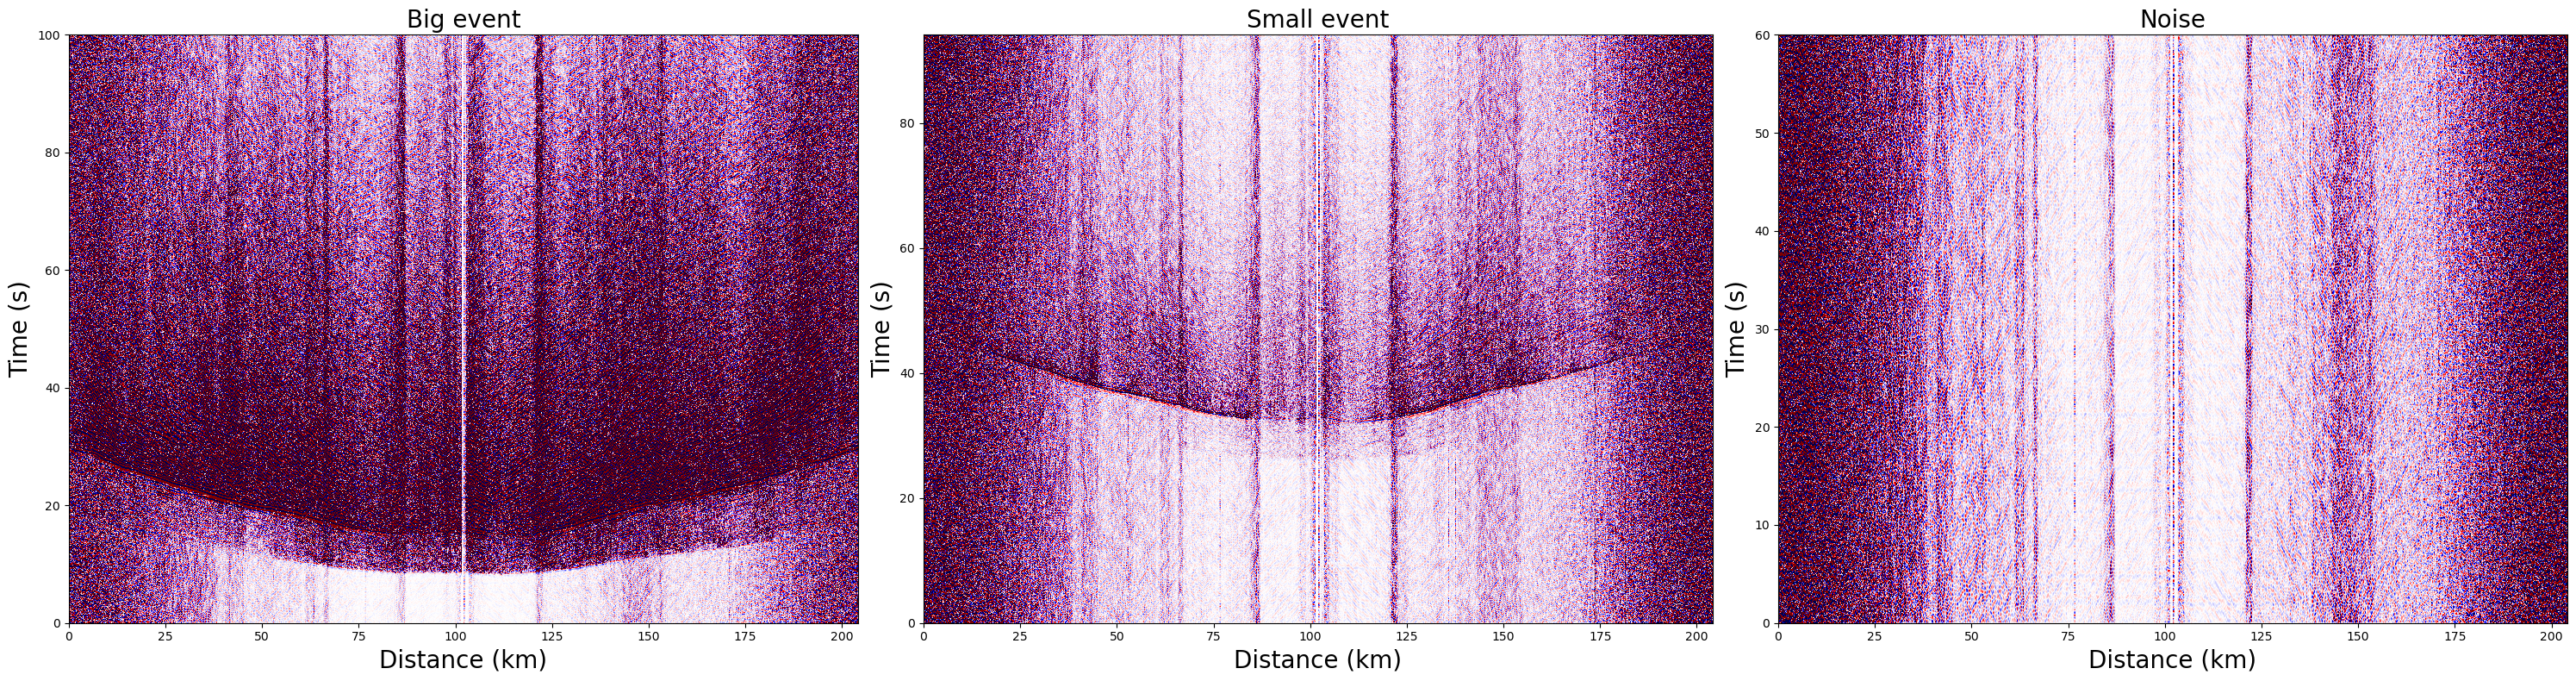

In [8]:
#cutting mjust the swave
vm_big = 1
vm_small=0.5

# Compute your extent arrays (distance vs time)
extent_big   = [ x_full_big[0]/1000, x_full_big[-1]/1000, 0, t_big[-1] ]
extent_small = [ x_full_small[0]/1000,     x_full_small[-1]/1000,     0, t_small[-1] ]
extent_noise = [ x_noise[0]/1000,          x_noise[-1]/1000,          0, t_noise[-1] ]

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

# Big event
axs[0].imshow(full_bigfil,
              aspect='auto',
              cmap='seismic',
              vmin=-vm_big, vmax=vm_big,
              origin='lower',
              extent=extent_big)
axs[0].set_xlabel('Distance (km)',fontsize=20)
axs[0].set_ylabel('Time (s)',fontsize=20)
axs[0].set_title('Big event',fontsize=20)
#axs[0].set_ylim(0,5)

# Small event
axs[1].imshow(full_smallfil,
              aspect='auto',
              cmap='seismic',
              vmin=-vm_small, vmax=vm_small,
              origin='lower',
              extent=extent_small)
axs[1].set_xlabel('Distance (km)',fontsize=20)
axs[1].set_ylabel('Time (s)',fontsize=20)
axs[1].set_title('Small event',fontsize=20)
#axs[1].set_ylim(0,5)

# Noise
axs[2].imshow(full_noise,
              aspect='auto',
              cmap='seismic',
              vmin=-vm_small, vmax=vm_small,
              origin='lower',
              extent=extent_noise)
axs[2].set_xlabel('Distance (km)',fontsize=20)
axs[2].set_ylabel('Time (s)',fontsize=20)
axs[2].set_title('Noise',fontsize=20)

#plt.savefig('bigsmallnoise.png', dpi=300)
plt.tight_layout()


### Computing NMO with the cable coords

[625 625 625 ... 779 779 779]


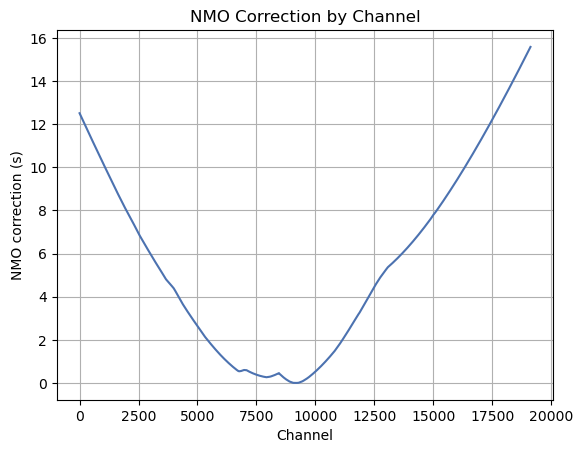

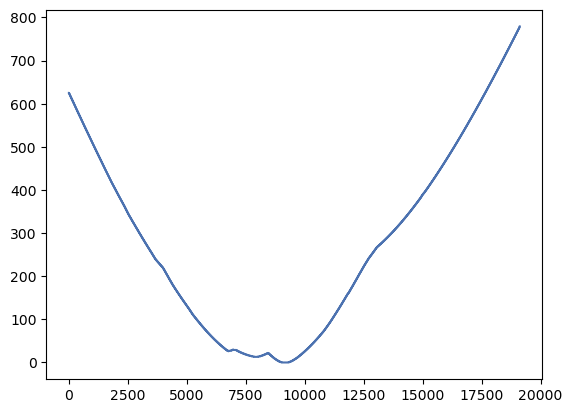

In [9]:
#  Load cable coordinates from CSV ---
df = pd.read_csv("terra-kkfln_cablecoord.csv")  # or your filepath
df.shape

# Convert (lon, lat) to meters using UTM ---
# Alaska is in UTM Zone 5N → EPSG:32605

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32605", always_xy=True)

x_das, y_das = transformer.transform(df['lon'].values, df['lat'].values)
z_das = np.zeros_like(x_das)  # assume cable is at surface (z = 0)

#Define the event location (source) - big quake
event_lon = -151.538
event_lat = 59.425
event_depth_km = 43.3
v = 3500  # velocity in m/s
# Convert source to meters
x0, y0 = transformer.transform(event_lon, event_lat)
z0 = -event_depth_km * 1000  # positive depth → negative elevation

# --- 4. Compute travel time to each channel ---
xoffsets = x_das - x0
yoffsets = y_das - y0
zoffsets = z_das - z0

# Euclidean distance in 3D → divide by velocity to get time
travel_times = np.sqrt((xoffsets / v)**2 + (yoffsets / v)**2 + (zoffsets / v)**2)
moveout_times = travel_times 

# .Compute relative NMO correction ---
nmo_correction = travel_times - np.min(travel_times)
nmo_samples    = nmo_correction//dt
nmo_samples = nmo_samples.astype(int)
print(nmo_samples)

# --- 6. Save or append to dataframe ---
df['NMO_terra-kkfln'] = nmo_correction

# Optional: save to CSV
df.to_csv("NMO_terra-kkfln.csv", index=False)

plt.plot(df['channel'], df['NMO_terra-kkfln'])
plt.xlabel("Channel")
plt.ylabel("NMO correction (s)")
plt.title("NMO Correction by Channel")
plt.grid(True)
plt.show()

plt.figure()

plt.plot(df['channel'], nmo_samples)



In [10]:
#Also innecsary step, just for visualization

# 1) window length
t_windowed = np.arange(window_len) * dt  # time of x 0→tmax

# 2) Same length and data moveout_times 
n_drop = full_smallfil.shape[1] - len(moveout_times)

full_bigfil   = full_bigfil[:,   n_drop:]
full_smallfil = full_smallfil[:, n_drop:]
full_noise    = full_noise[:,    n_drop:]

das_full_big  = das_full_big[:,   n_drop:]
das_full_small= das_full_small[:, n_drop:]


(19122,)
(5000, 19122)


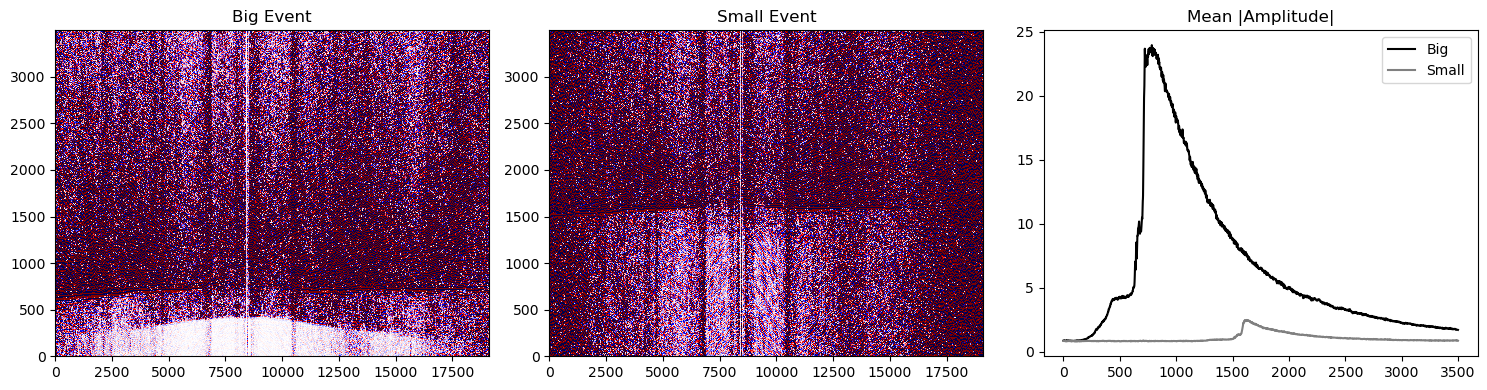

In [11]:
# Correct NMO for entire trace matrix

print(np.shape(nmo_samples))
print(np.shape(full_bigfil))

big_dataf   = np.zeros((3500,np.shape(full_bigfil)[1]))
small_dataf = np.zeros((3500,np.shape(full_smallfil)[1]))
raw_big     = np.zeros((3500,np.shape(das_full_big)[1]))
raw_small     = np.zeros((3500,np.shape(das_full_small)[1]))

for i in range(len(nmo_samples)):
    big_dataf[:,i]   = full_bigfil[nmo_samples[i]:nmo_samples[i]+3500,i] # filtered
    small_dataf[:,i] = full_smallfil[nmo_samples[i]:nmo_samples[i]+3500,i] 
    raw_big[:,i]     = das_full_big[nmo_samples[i]:nmo_samples[i]+3500,i] 
    raw_small[:,i]   = das_full_small[nmo_samples[i]:nmo_samples[i]+3500,i] 
#full_smallfil
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# First plot: big_dataf
axs[0].imshow(big_dataf, cmap='seismic', vmin=-0.8, vmax=0.8, origin='lower', aspect='auto')
axs[0].set_title("Big Event")

# Second plot: small_dataf
axs[1].imshow(small_dataf, cmap='seismic', vmin=-0.05, vmax=0.05, origin='lower', aspect='auto')
axs[1].set_title("Small Event")

# Third plot: mean absolute amplitude
axs[2].plot(np.nanmean(np.abs(big_dataf), axis=1), label="Big", color='black')
axs[2].plot(np.nanmean(np.abs(small_dataf), axis=1), label="Small", color='gray')
axs[2].set_title("Mean |Amplitude|")
axs[2].legend()

plt.tight_layout()
plt.show()


In [12]:
# Find index of max absolute amplitude over time (axis=0 is time)
big_idx = np.argmax(np.nanmean(np.abs(big_dataf), axis=1))
small_idx = np.argmax(np.nanmean(np.abs(small_dataf), axis=1))

In [13]:
pre_sec  = 5  # 2  # sec beforer arrival
post_sec = 10 # 10  # sec after arrival
#in samples
pre_samples  = int(pre_sec / dt)
post_samples = int(post_sec/ dt)
# index
bstart_idx = max(big_idx - pre_samples, 0)
bend_idx   = min(big_idx + post_samples, big_dataf.shape[0])

sstart_idx = max(small_idx - pre_samples, 0)
send_idx   = min(small_idx + post_samples, small_dataf.shape[0])

#cuts
big_cut   = big_dataf[bstart_idx:bend_idx, :]
small_cut = small_dataf[sstart_idx:send_idx, :]

raw_big_cut   = raw_big[bstart_idx:bend_idx, :]
raw_small_cut = raw_small[sstart_idx:send_idx, :]


### Correcting or aligning DAS data after moveout

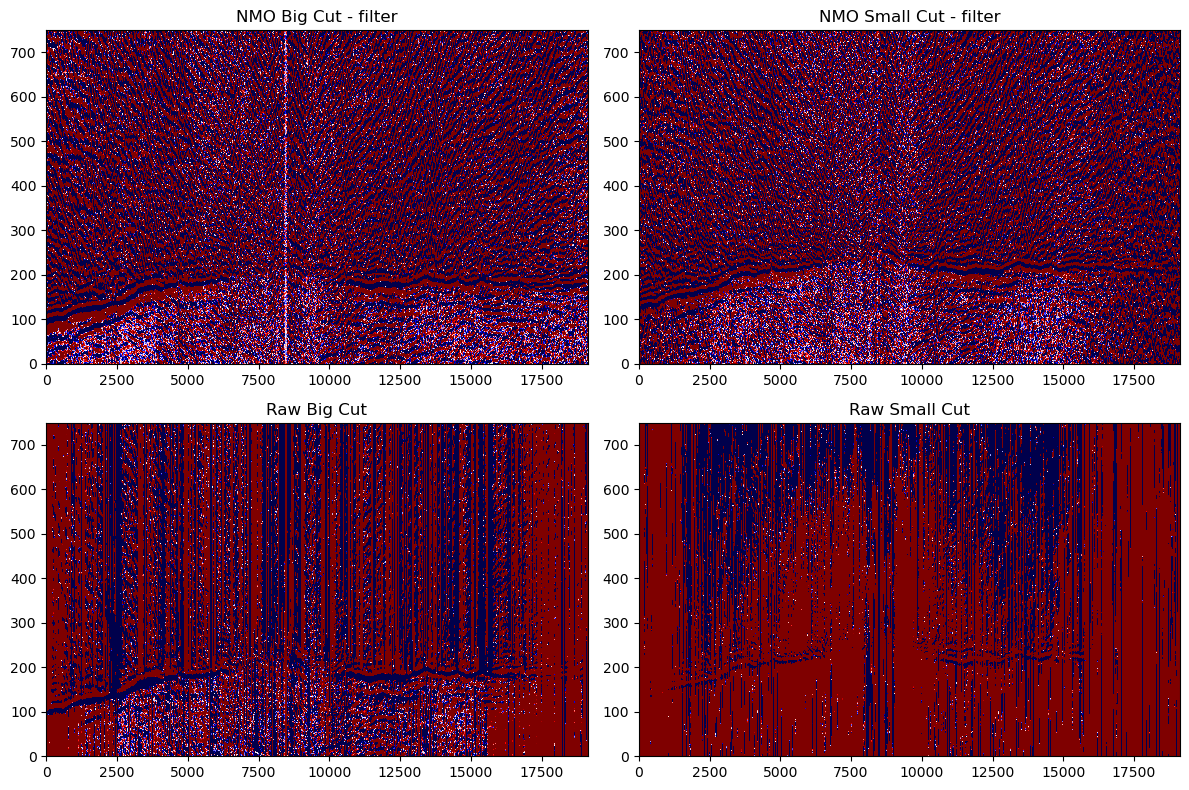

In [14]:
# Plot event cut filter and rwa
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(big_cut, cmap='seismic', vmin=-0.8, vmax=0.8, origin='lower', aspect='auto')
plt.title("NMO Big Cut - filter")

plt.subplot(2, 2, 2)
plt.imshow(small_cut, cmap='seismic', vmin=-0.05, vmax=0.05, origin='lower', aspect='auto')
plt.title("NMO Small Cut - filter")

plt.subplot(2, 2, 3)
plt.imshow(raw_big_cut, cmap='seismic', vmin=-0.8, vmax=0.8, origin='lower', aspect='auto')
plt.title("Raw Big Cut")

plt.subplot(2, 2, 4)
plt.imshow(raw_small_cut, cmap='seismic', vmin=-0.05, vmax=0.05, origin='lower', aspect='auto')
plt.title("Raw Small Cut")

plt.tight_layout()
plt.show()


In [15]:
raw_small_cut.shape

(750, 19122)

### Calculate the spectral ratio

Here good practices, should be:

**1.- rest the mean do the data (detrend)

**2.- no just do ft_b/ft_s **

**3.- calculate $ft_b*ft_s*/abs(ft_s)**2$

**4.- maybe a water level thing **

In [16]:
def hanning_detrend(x, fmin=1, fmax=10, dt=0.02):
    '''
    x = DAS data
    data_ready = Das data ready to work with fft
    '''
    npts, n_chan   = x.shape
    hann   = np.hanning(npts)
    
    b, a = butter(2, [fmin, fmax], btype='bandpass', fs=1/dt)
    data_ready = np.empty_like(x)

    for i in range(n_chan):
        trace       = x[:,i]
        trace_detre = signal.detrend(trace)  # just resting the mean 
        trace_tap   = trace_detre * hann
        #trace_filt  = filtfilt(b, a, trace_tap) no need for filter
        data_ready[:, i] = trace_tap 
        
    return data_ready

In [17]:
# Apply  Hanning and detrend
big_detrend   = hanning_detrend(raw_big_cut, fmin=1, fmax=10, dt=0.02)#, mode='hanning')
small_detrend = hanning_detrend(raw_small_cut, fmin=1, fmax=10, dt=0.02)#, mode='hanning')

In [18]:
fft_small = fftshift(fft(small_detrend, axis=0), axes=0)
p_small = abs(fft_small)**2
print(len(fft_small))
fft_big =  fftshift(fft(big_detrend, axis=0), axes=0)
print(len(fft_big))

750
750


# come back to t
get the source time fuction plot
compare with the previous version
calculate corner frequency
calculate stress drop


In [19]:
# Power spectrum,
p_small = np.abs(fft_small)**2
epsilon  =1e-16
# Ratio espectral complejo
Ratio = fft_big[0:len(fft_small)]* np.conj(fft_small) / (p_small+epsilon)  # no divide by zero

nt = fft_small.shape[0]

f = np.fft.fftfreq(nt, d=dt)
f = fftshift(f)
dt = 0.02

#Ratio = Ratio[:,0:18500] deleting the bad channels hehe

# --- Inverse FFT back to time domain ---
ratio_time = ifft(ifftshift(Ratio, axes=0), axis=0)
fmin=1
fmax=10
# --- Average over channels ---
ratio_avg = np.mean(ratio_time.real, axis=1)

# --- Bandpass filter ---
b, a = butter(2, [fmin, fmax], btype='bandpass', fs=1/dt)
ratio_smooth = filtfilt(b, a, ratio_avg)

# --- Time axis ---
t_nmo = np.arange(len(ratio_avg)) * dt

# comeback to the time domain
stf_complex = ifft(ifftshift(Ratio, axes=0), axis=0)

# stacking
stf_avg = np.mean(stf_complex.real, axis=1)
b, a = butter(2, [1, 10], btype='bandpass', fs=1/dt)
stf_smooth = filtfilt(b, a, stf_avg)
t_stf = np.arange(len(stf_smooth)) * dt

print(np.max(np.abs(ratio_smooth)))
print(np.max(np.abs(stf_smooth)))


1.3052632569948244
1.3052632569948244


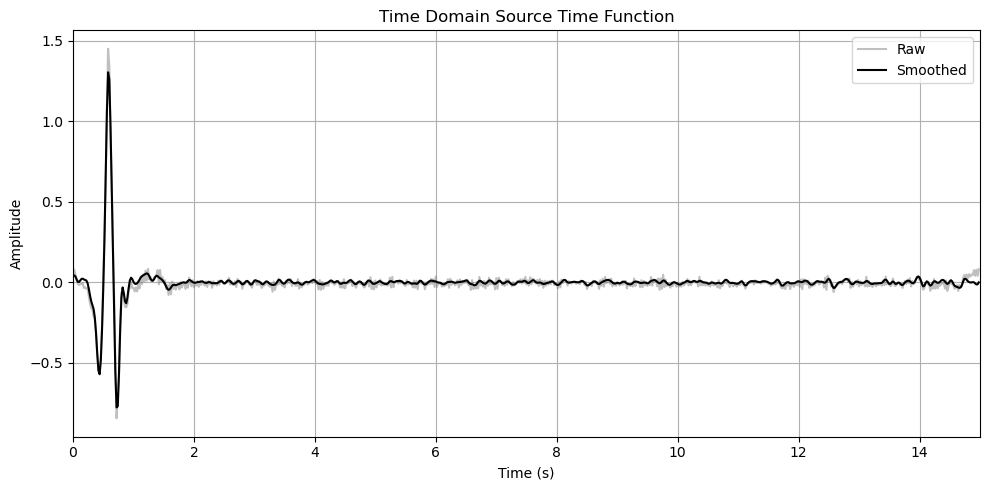

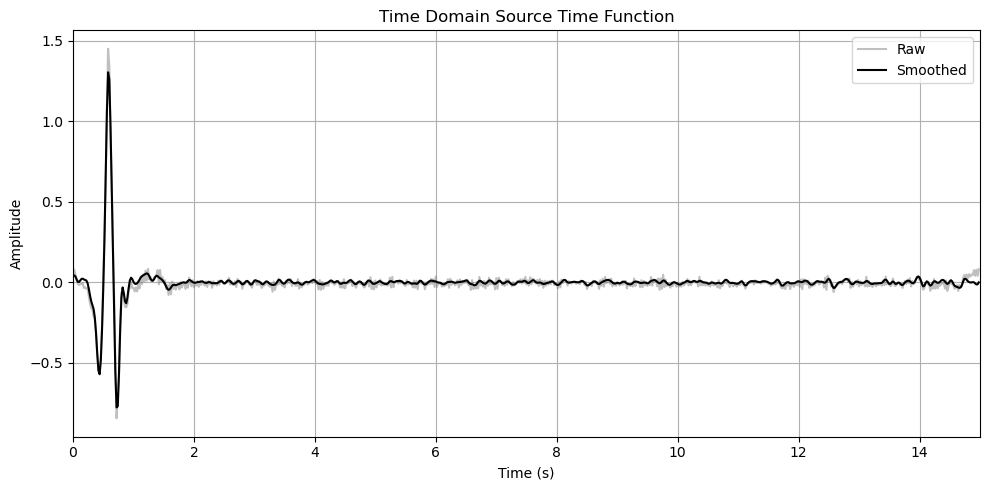

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_stf, stf_avg[::-1], color='gray', alpha=0.5, label='Raw')
ax.plot(t_stf, stf_smooth[::-1], '-k', label='Smoothed')

ax.set_title('Time Domain Source Time Function')
ax.set_xlabel('Time (s)')
ax.set_xlim([0, 15])
#ax.set_ylim([-0.25, 0.25])
ax.set_ylabel('Amplitude')
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_nmo, ratio_avg[::-1], color='gray', alpha=0.5, label='Raw')
ax.plot(t_nmo, ratio_smooth[::-1], '-k', label='Smoothed')

ax.set_title('Time Domain Source Time Function')
ax.set_xlabel('Time (s)')
ax.set_xlim([0, 15])
#ax.set_ylim([-0.25, 0.25])
ax.set_ylabel('Amplitude')
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()


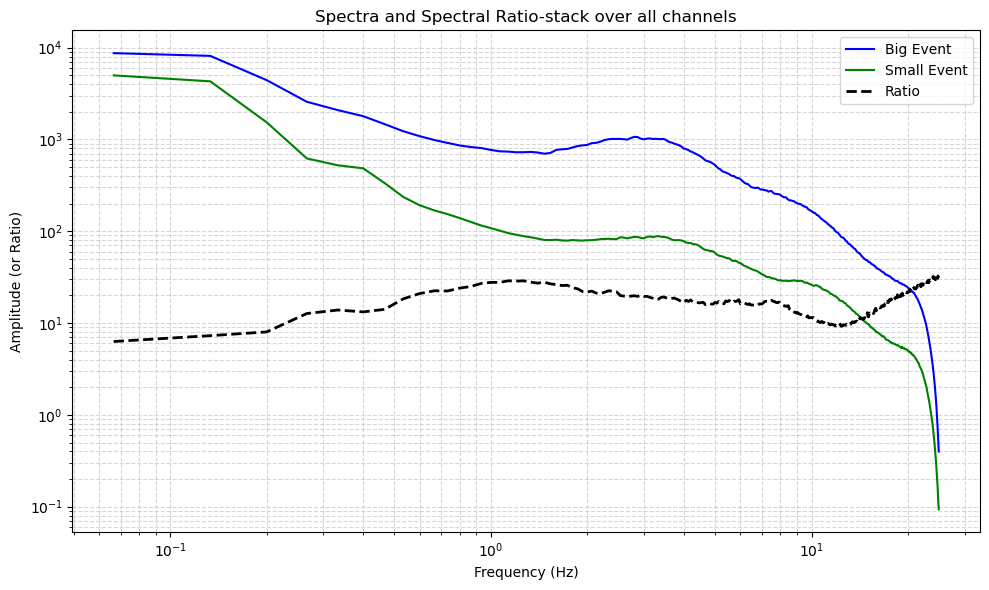

In [21]:
# Magnitudes promediadas por canal
mag_big   = np.mean(np.abs(fft_big[0:len(fft_small)][f > 0, :]), axis=1)
mag_small = np.mean(np.abs(fft_small[f > 0, :]), axis=1)
mag_ratio = np.mean(np.abs(Ratio[f > 0, :]), axis=1)

# Eje de frecuencia positiva
f_pos = f[f > 0]

# Plot
plt.figure(figsize=(10,6))
plt.loglog(f_pos, mag_big,   label='Big Event',   color='blue')
plt.loglog(f_pos, mag_small, label='Small Event', color='green')
plt.loglog(f_pos, mag_ratio, label='Ratio',       color='black', linestyle='--',linewidth=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (or Ratio)")
plt.title("Spectra and Spectral Ratio-stack over all channels")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('spectumfrequencydomain_10', dpi = 300)
plt.show()


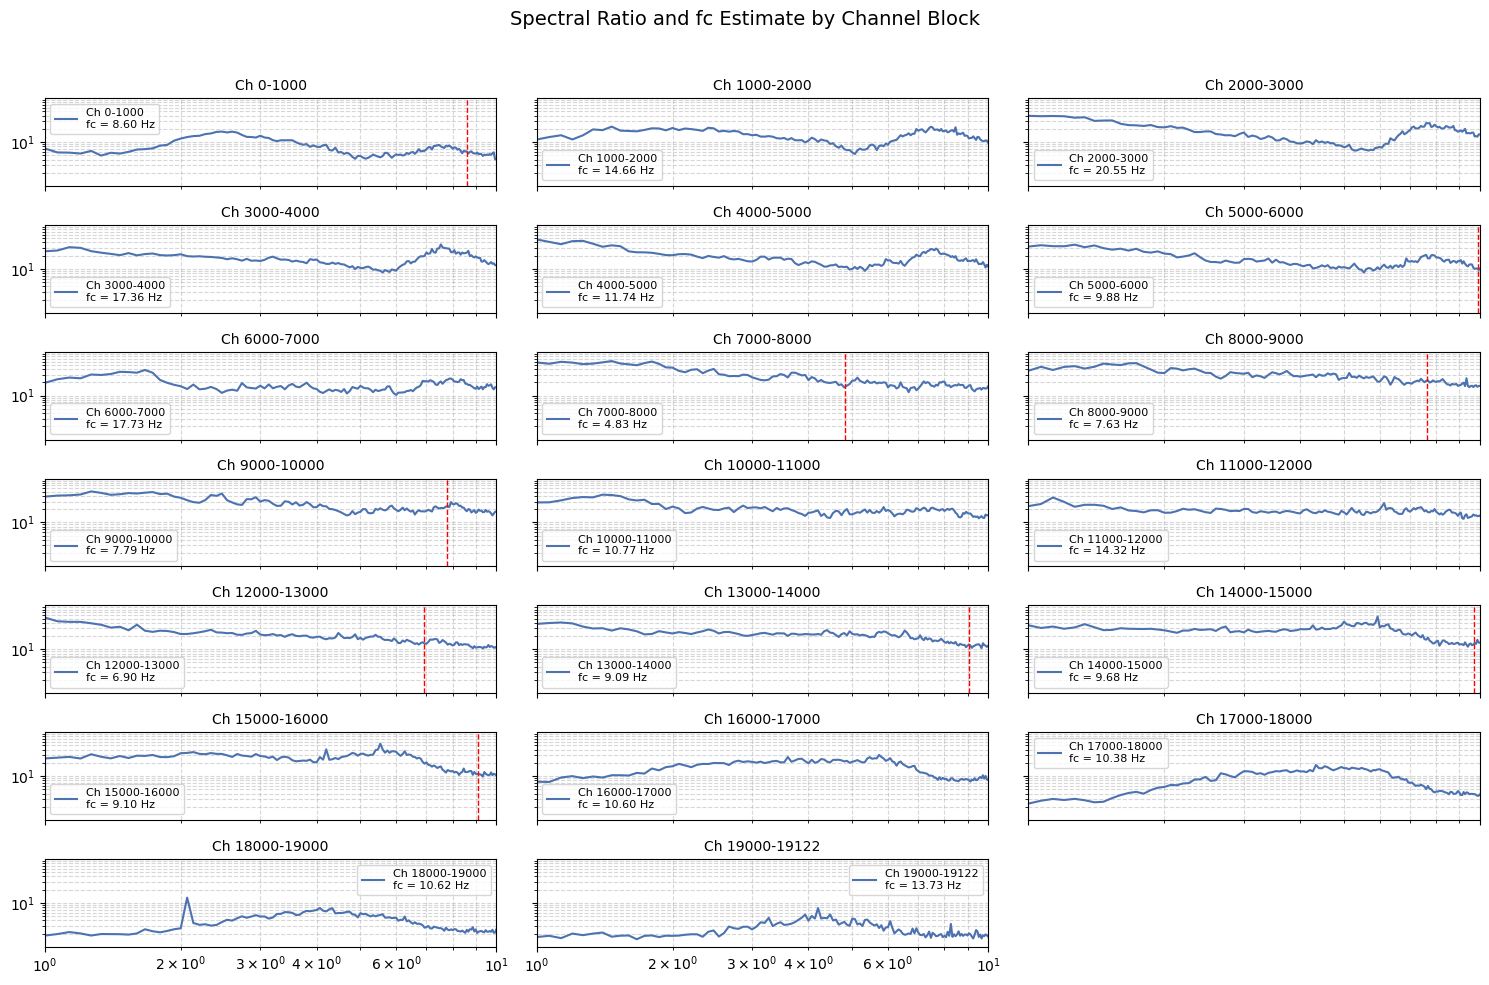

In [22]:
# Define Brune model
def brune_model(f, A0, fc):
    return A0 / (1 + (f / fc)**2)

# Parameters
step = 1000
n_cha = fft_small.shape[1]
indices = np.arange(0, n_cha, step)
fmin_fit = 1
fmax_fit = 12
fc_values = []

# Frequencies
f_pos = f[f > 0]

# Setup subplots
n_plots = len(indices)
ncols = 3
nrows = int(np.ceil(n_plots / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over blocks
for i, ind in enumerate(indices):
    if i >= len(axs):
        break
    ind_end = min(ind + step, n_cha)
    
    # Extract subarrays
    sub_big   = np.abs(fft_big[:, ind:ind_end])**2
    sub_small = np.abs(fft_small[:, ind:ind_end])**2
    sub_ratio = np.abs(Ratio[:, ind:ind_end])
    ratio_avg = np.mean(sub_ratio[f > 0, :], axis=1)

    # Fit Brune model
    mask = (f_pos > fmin_fit) & (f_pos < fmax_fit)
    try:
        popt, _ = curve_fit(brune_model, f_pos[mask], ratio_avg[mask], p0=(np.max(ratio_avg[mask]), 3.0))
        fc = popt[1]
    except RuntimeError:
        fc = np.nan

    fc_values.append(fc)

    # Plot in subplot
    ax = axs[i]
    ax.loglog(f_pos, ratio_avg, label=f'Ch {ind}-{ind_end}\nfc = {fc:.2f} Hz')
    ax.axvline(fc, color='red', linestyle='--', linewidth=1) 
    ax.set_xlim(1,10)
    ax.set_title(f'Ch {ind}-{ind_end}', fontsize=10)
    ax.grid(True, which='both', ls='--', alpha=0.5)
    ax.legend(fontsize=8)

# Hide unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Spectral Ratio and fc Estimate by Channel Block", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


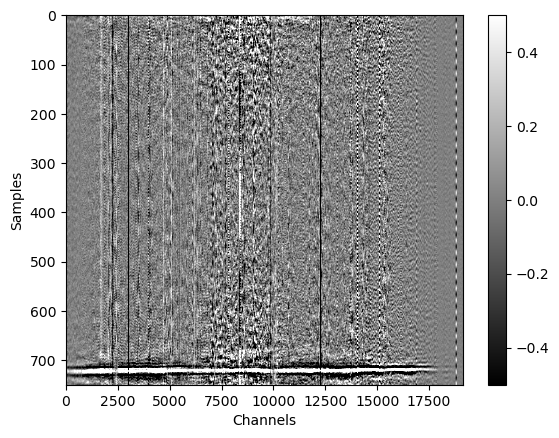

In [23]:
plt.subplots()
c=plt.imshow(np.real(ratio_time),aspect='auto',cmap='gray',vmin=-0.5,vmax=0.5)
plt.colorbar(c)

plt.xlabel('Channels')
plt.ylabel('Samples')
plt.show()

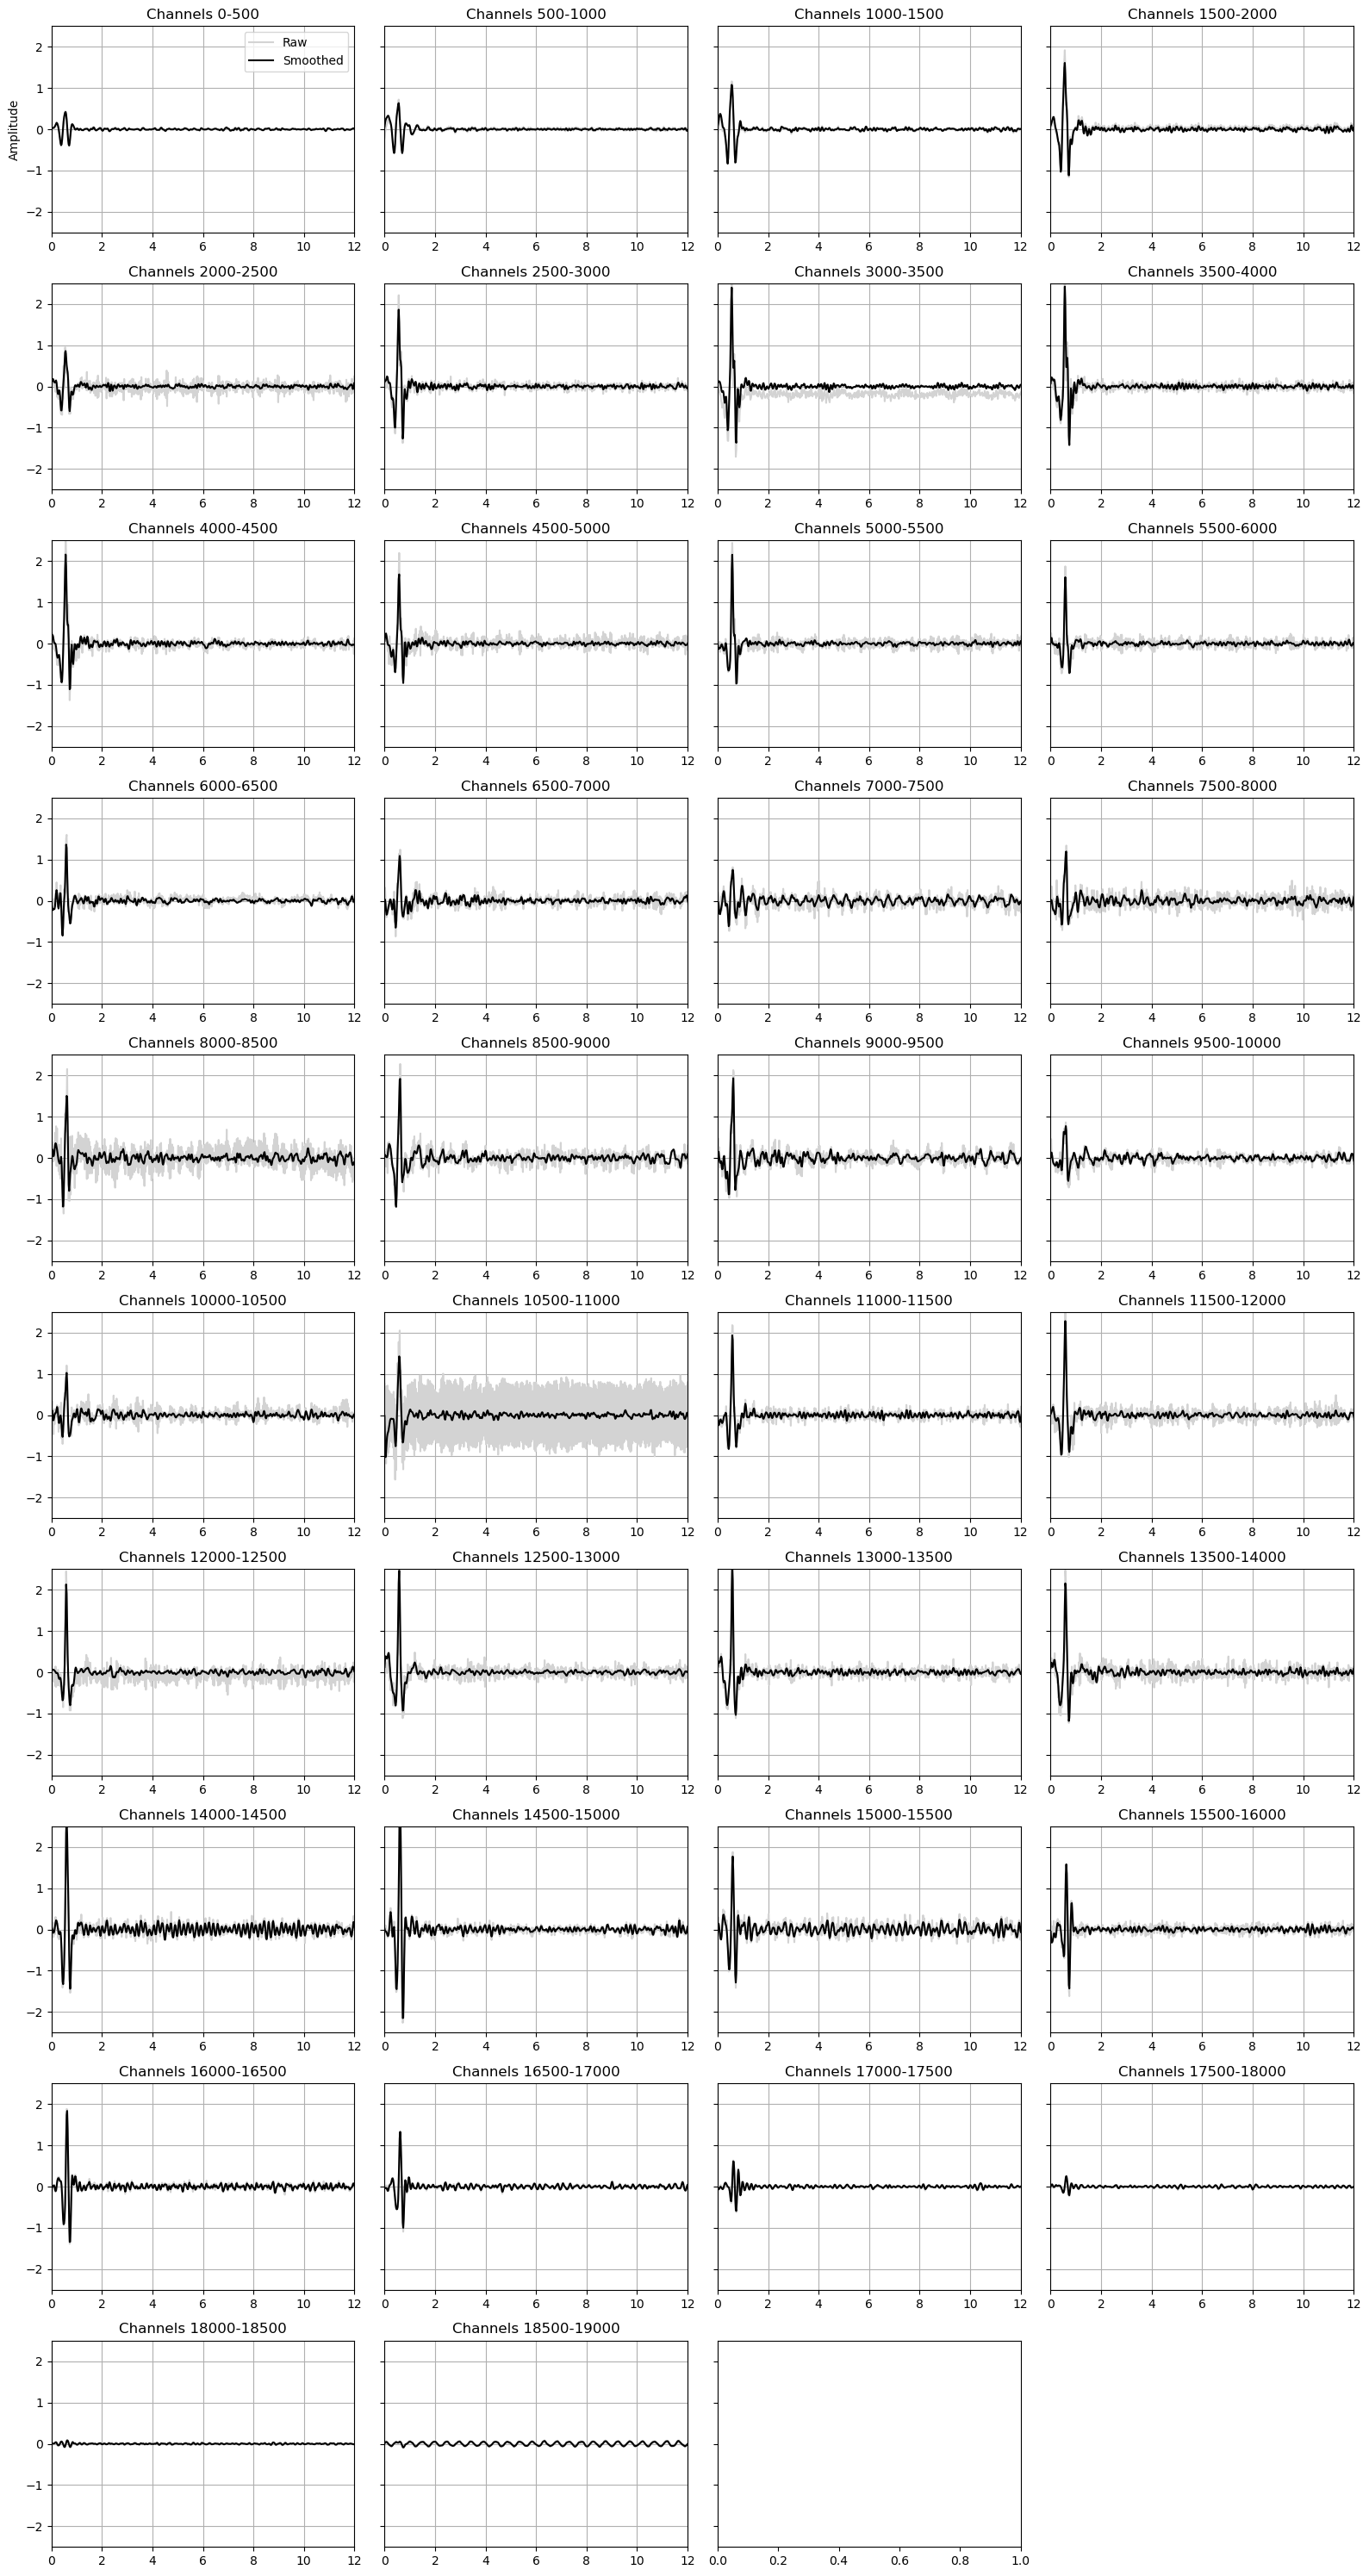

In [24]:
n_channels = fft_big.shape[1]
dx = 500

# Compute starting indices: 0, 500, 1000, ..., up to n_channels - dx
start_indices = np.arange(0, n_channels, dx)

# Number of subplots
n_panels = len(start_indices)

# Plot setup (let's do it in rows if it's too many)
n_cols = 4
n_rows = int(np.ceil(n_panels / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharey=True)
axs = axs.flatten()  # flatten in case it's 2D

for i, ind in enumerate(start_indices):
    if ind + dx > n_channels:
        break  # skip incomplete last block

    # Subsets
    fft_big_seg = fft_big[:, ind:ind + dx]
    fft_small_seg = fft_small[:, ind:ind + dx]
    p_small_seg = np.abs(fft_small_seg)**2
    Ratio_seg = fft_big_seg * np.conj(fft_small_seg) / (p_small_seg + 1e-12)

    # IFFT
    ratio_time = ifft(ifftshift(Ratio_seg, axes=0), axis=0)
    ratio_avg = np.mean(ratio_time.real, axis=1)
    ratio_smooth = filtfilt(b, a, ratio_avg)

    # Plot
    axs[i].plot(t_nmo, ratio_avg[::-1], color='lightgray', label='Raw')
    axs[i].plot(t_nmo, ratio_smooth[::-1], '-k', label='Smoothed')
    axs[i].set_title(f'Channels {ind}-{ind + dx}')
    axs[i].set_xlim([0, 12])
    axs[i].set_ylim([-2.5, 2.5])
    axs[i].grid()

# Labels and cleanup
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Hide unused subplots if any
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


Attempt to calculate corner frequency

In [25]:
Ratio_mag = np.abs(Ratio[f > 0, :])  # only positve
Ratio_avg = np.mean(Ratio_mag, axis=1)
f_pos = f[f > 0]

Estimated corner frequency: 9.90 Hz


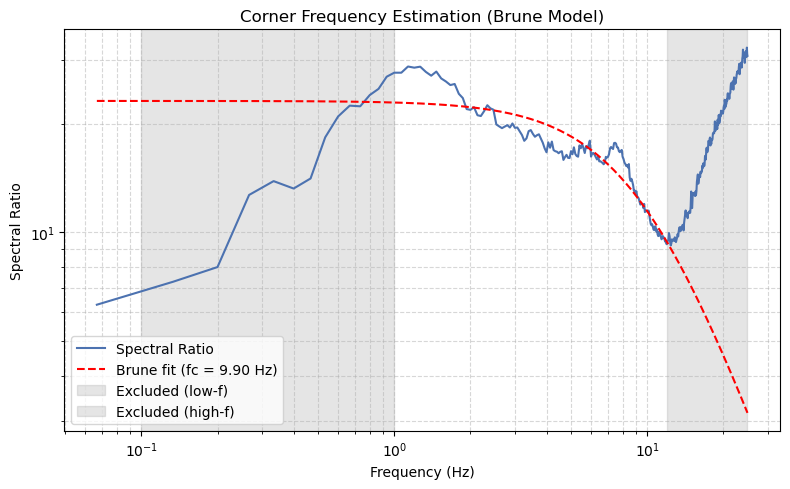

In [26]:
#  Brune model
def brune_model(f, A0, fc):
    return A0 / (1 + (f / fc)**2)

good_ratio = np.abs(Ratio[:, :])  # Only channels >= 17500
Ratio_avg = np.mean(good_ratio[f > 0, :], axis=1)
# Trim edges
fmin_fit = 1
fmax_fit = 12
mask = (f_pos > fmin_fit) & (f_pos < fmax_fit)

# Apply fit only in the good region
f_fit = f_pos[mask]
ratio_fit = Ratio_avg[mask]

# Fit model
popt, _ = curve_fit(brune_model, f_fit, ratio_fit, p0=(np.max(ratio_fit), 3.0))
A0_fit, fc_fit = popt
print(f"Estimated corner frequency: {fc_fit:.2f} Hz")

# Plot result
plt.figure(figsize=(8, 5))
plt.loglog(f_pos, Ratio_avg, label='Spectral Ratio')
plt.loglog(f_pos, brune_model(f_pos, *popt), 'r--', label=f'Brune fit (fc = {fc_fit:.2f} Hz)')
plt.axvspan(0.1, fmin_fit, color='gray', alpha=0.2, label='Excluded (low-f)')
plt.axvspan(fmax_fit, f_pos[-1], color='gray', alpha=0.2, label='Excluded (high-f)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Spectral Ratio")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.title("Corner Frequency Estimation (Brune Model)")
plt.tight_layout()
plt.show()
